<a href="https://colab.research.google.com/github/denisangelo/Federated_Learning/blob/main/ExemploCryptenRegressaoLogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importa Pytorch,crypten
!pip install crypten
!pip install torch
!pip install torchvision
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importa as bibliotecas necessárias
import matplotlib.pyplot as plt
import numpy as np
import crypten
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10

In [ ]:
crypten.init()
torch.set_num_threads(1)

In [ ]:
#Carrega os dados CIFAR10

#transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor(),])
trainset = CIFAR10(root="./data", train=True,download=True, transform=transform)
testset = CIFAR10(root="./data", train=False, download=True, transform=transform)
#labels
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 73059257.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print('Tamanho do conjunto de treino:', len((trainset)))
print('Tamanho do conjunto de teste:', len((testset)))

Tamanho do conjunto de treino: 50000
Tamanho do conjunto de teste: 10000


Esta imagem é um: frog


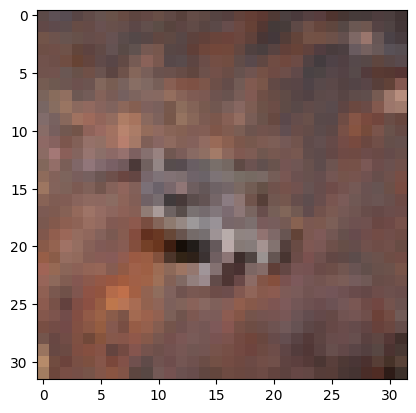

In [ ]:
example = 347

image, label = trainset[example]

print("Esta imagem é um: " + classes[(trainset[example])[1]])
plt.imshow(image.permute(1,2,0))




In [ ]:
train_dl = DataLoader(trainset, batch_size=64,shuffle=True)
test_dl= DataLoader(testset, batch_size=64)

In [ ]:
print('Tamanho do conjunto de treino:', len((train_dl)))
print('Tamanho do conjunto de teste:', len((test_dl)))

Tamanho do conjunto de treino: 782
Tamanho do conjunto de teste: 157


In [ ]:
def show_batch(dl):
 for image, label in dl:
  fig,ax = plt.subplots(figsize =(10,5))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(image,nrow=16).permute(1,2,0))
  break


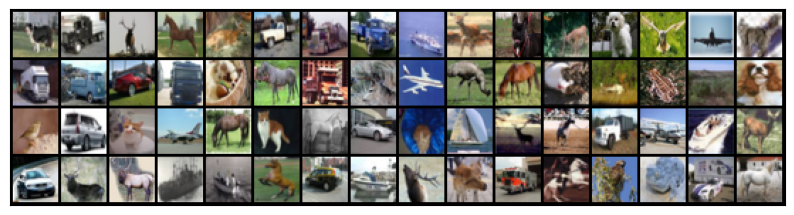

In [ ]:
show_batch(train_dl)

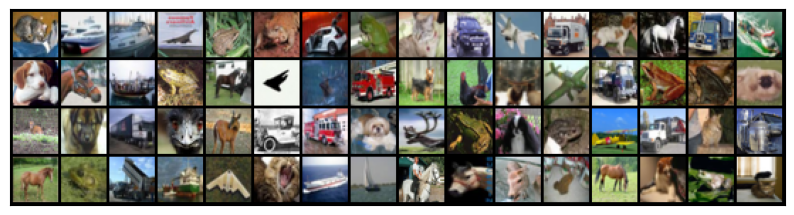

In [ ]:
show_batch(test_dl)

In [ ]:
#Pré processamento entre tensores
def take_samples(trainset, n_samples=5000):
  #Retorna images e labels em conjunto de amostras
  images,labels =[],[]
  for i,trainset in enumerate(trainset):
    if i==n_samples:
      break
    image, label = trainset
    images.append(image)
    label_one_hot = torch.nn.functional.one_hot(torch.tensor(label),10)
    labels.append(label_one_hot)

  images = torch.cat(images)
  labels = torch.stack(labels)
  return images,labels

In [ ]:
images,labels = take_samples(trainset, n_samples=5000)

In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([15000, 32, 32])
torch.Size([5000, 10])


In [ ]:
images_enc = crypten.cryptensor(images)
labels_enc = crypten.cryptensor(labels)

In [ ]:
images_enc[3]

MPCTensor(
	_tensor=tensor([[20303, 22359, 23387,  ..., 26985, 32382, 39578],
        [18247, 19789, 24672,  ..., 32125, 37265, 35980],
        [17219, 17476, 20303,  ..., 29555, 35723, 35980],
        ...,
        [23901, 15677, 10794,  ..., 39578, 40092, 44975],
        [33667, 31611, 26471,  ..., 40863, 40092, 42405],
        [36751, 36751, 36751,  ..., 41891, 40606, 41891]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [ ]:
images_enc[3].unsqueeze(0)

MPCTensor(
	_tensor=tensor([[[20303, 22359, 23387,  ..., 26985, 32382, 39578],
         [18247, 19789, 24672,  ..., 32125, 37265, 35980],
         [17219, 17476, 20303,  ..., 29555, 35723, 35980],
         ...,
         [23901, 15677, 10794,  ..., 39578, 40092, 44975],
         [33667, 31611, 26471,  ..., 40863, 40092, 42405],
         [36751, 36751, 36751,  ..., 41891, 40606, 41891]]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [ ]:
x=images_enc[3].unsqueeze(0)
print(x.shape)


torch.Size([1, 32, 32])


In [ ]:
#Conjunto de imagens de teste
images_test,labels_test = take_samples(testset, n_samples=1000)
images_test_enc = crypten.cryptensor(images_test)
labels_test_enc = crypten.cryptensor(labels_test)

In [ ]:
#Modelo de regressão Logística
class LogisticRegression(crypten.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = crypten.nn.Linear(3*32*32,10)
  def forward(self,x):
    x=x.reshape(-1,3072)
    out =self.linear(x)
    return out

In [ ]:
model = LogisticRegression().encrypt()

In [ ]:
model.linear

Linear encrypted module

In [ ]:
model(images_enc)

MPCTensor(
	_tensor=tensor([[ 32063, -15335,  24061,  ...,  -9406,  -2777, -32405],
        [ 27174, -16148,   4847,  ...,  -6261,  20834, -32506],
        [ 61467,  -8378,  25784,  ..., -20626,  10647, -29347],
        ...,
        [ 50275, -18051,  15536,  ..., -16364,  12103, -25343],
        [ 49485, -18262,  28291,  ..., -12648,   3942, -36060],
        [ 30095, -20568,  11399,  ...,  -5466,   4221,  -7235]])
	plain_text=HIDDEN
	ptype=ptype.arithmetic
)

In [ ]:
#Modelo de Treinamento em imagens criptografadas
def train_model(model, X, y, epochs=1000, learning_rate=0.001):
    criterion = crypten.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        print(f"epoch {epoch} loss: {loss.get_plain_text()}")
        loss.backward()
        model.update_parameters(learning_rate)
    return model

In [ ]:
model = train_model(model, images_enc, labels_enc)

epoch 0 loss: 2.3438568115234375
epoch 1 loss: 2.338836669921875
epoch 2 loss: 2.3343658447265625
epoch 3 loss: 2.33038330078125
epoch 4 loss: 2.32684326171875
epoch 5 loss: 2.3236236572265625
epoch 6 loss: 2.3206939697265625
epoch 7 loss: 2.31805419921875
epoch 8 loss: 2.3157806396484375
epoch 9 loss: 2.313720703125
epoch 10 loss: 2.311920166015625
epoch 11 loss: 2.310272216796875
epoch 12 loss: 2.30877685546875
epoch 13 loss: 2.3073577880859375
epoch 14 loss: 2.3060760498046875
epoch 15 loss: 2.304901123046875
epoch 16 loss: 2.303863525390625
epoch 17 loss: 2.3028411865234375
epoch 18 loss: 2.301910400390625
epoch 19 loss: 2.301025390625
epoch 20 loss: 2.3001556396484375
epoch 21 loss: 2.2993011474609375
epoch 22 loss: 2.298492431640625
epoch 23 loss: 2.2977294921875
epoch 24 loss: 2.2969512939453125
epoch 25 loss: 2.2962646484375
epoch 26 loss: 2.2955474853515625
epoch 27 loss: 2.29486083984375
epoch 28 loss: 2.2942352294921875
epoch 29 loss: 2.2935638427734375
epoch 30 loss: 2.2929

In [ ]:
x=images_enc[0].unsqueeze(0)
print(x.shape)
u=x.reshape
print(u)


torch.Size([1, 32, 32])
<function CrypTensor._get_autograd_forward_function.<locals>.autograd_forward at 0x7efd53df8dc0>


In [ ]:
prediction = model(images_enc)


In [ ]:
print(prediction.get_plain_text())

tensor([[0.3604, 0.1731, 0.2836,  ..., 0.1898, 0.4457, 0.6611],
        [0.4939, 0.4166, 0.3475,  ..., 0.2111, 0.8494, 0.4658],
        [0.9483, 0.3985, 0.5030,  ..., 0.4369, 1.1619, 1.2206],
        ...,
        [0.6803, 0.2907, 0.4524,  ..., 0.2935, 0.8546, 0.9099],
        [0.7998, 0.1945, 0.4340,  ..., 0.4145, 0.7143, 0.7841],
        [0.2471, 0.2316, 0.1179,  ..., 0.3189, 0.4258, 0.2538]])


In [ ]:
prediction.get_plain_text().argmax()

tensor(8900)

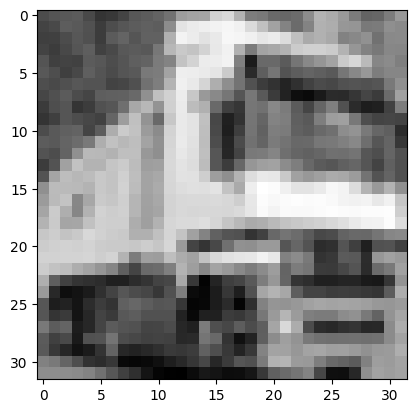

In [ ]:
plt.imshow(images[3], cmap='gray', interpolation='none')

In [ ]:
#Acurácia do Modelo
def avg_test_accuracy(model, X, y):
    output = model(X).get_plain_text().softmax(0)
    predicted = output.argmax(1)
    labels = y.get_plain_text().argmax(1)
    correct = (predicted == labels).sum().float()
    return float(correct / y.shape[0])

In [ ]:
acc= avg_test_accuracy(model, images_enc, labels_enc)
print('> %.3f' %(acc * 100.0))

> 19.920


In [ ]:
acc_test= avg_test_accuracy(model, images_test_enc, labels_test_enc)
print('> %.3f' %(acc_test * 100.0))

> 18.000
